# Analysis of SILAC-based comparative experiments

In this example we use data from a publication showing that certain yeast strains can under defined growth conditions incorporate externally added heavy-labelled amino acids into their proteins even though they are capable to produce these amino acids on their own, i.e. based on available unlabelled carbon-atoms (https://pubs.acs.org/doi/full/10.1021/acs.analchem.8b02557). The results from the analysis of mitochondrial gene deletion on the yeast proteome from this study is available through PRIDE with the iD PXD010019.

In [1]:
import sys, os
sys.path.append('../..')
from autoprot import preprocessing as pp
from autoprot import analysis as ana
from autoprot import visualization as vis

C:\Users\jub29yk\Anaconda3\envs\autoprot\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
import zipfile

# Get a dict mapping the files matching the keyword (2nd arg) to their ftp download link
ftp_links = pp.fetch_from_pride("PXD010019", "MaxQuant")
# download the MaxQuant results if they are not present in the folder
if not os.path.isfile("./maxquant.zip"):
    pp.download_from_ftp(ftp_links['maxquant.zip'], save_dir = '.')

archive = zipfile.ZipFile("./maxquant.zip", 'r')
txt = archive.open('MaxQuant/proteinGroups.txt')
pg = pp.read_csv(txt)

Found file maxquant.zip


## Inspection of channel intensities

In [3]:
pg = pp.cleaning(pg, file='proteinGroups')
pg, log_int_cols = pp.log(pg, cols=pg.filter(regex='Intensity (H|M|L) ').columns.to_list(), base=2, return_cols=True)

1126 rows before filter operation.
1088 rows after filter operation.


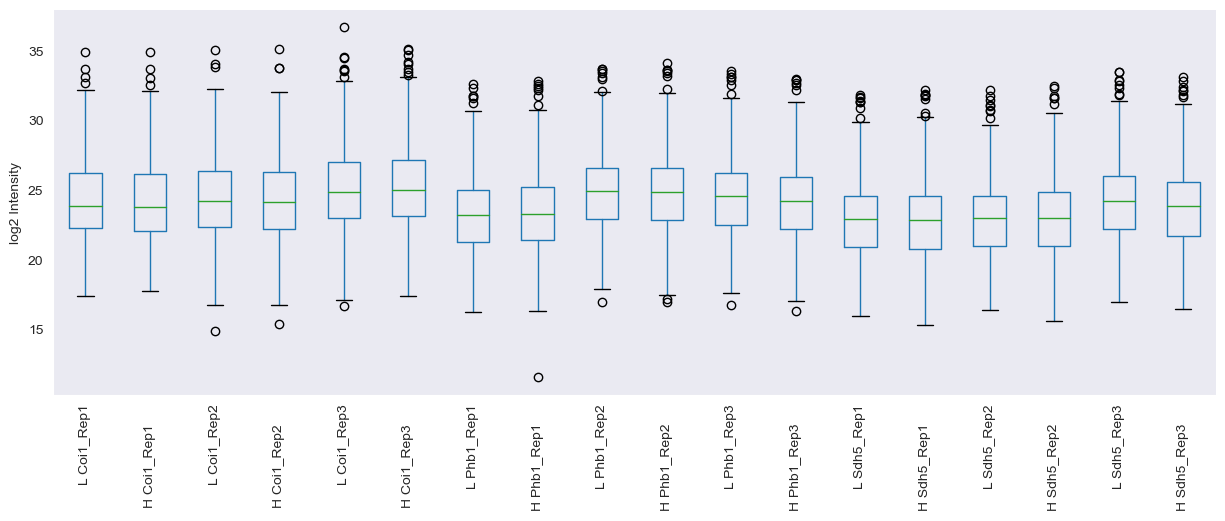

In [4]:
fig = vis.boxplot(df=pg, reps=log_int_cols, labels=[x[15:] for x in log_int_cols], ret_fig=True, ylabel='log2 Intensity')
ax = fig.get_axes()[0]
ax.tick_params(axis='x', rotation=90)

In [5]:
pg, norm_cols = pp.cyclic_loess(pg, log_int_cols, return_cols=True)

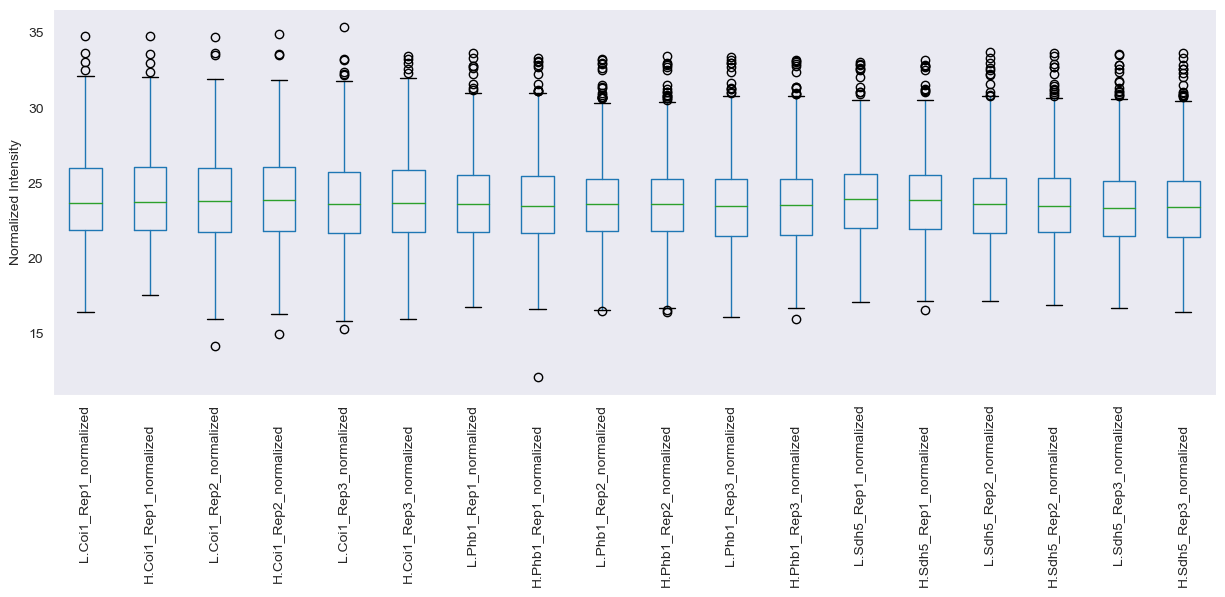

In [6]:
fig = vis.boxplot(df=pg, reps=norm_cols, labels=[x[15:] for x in norm_cols], ret_fig=True, ylabel='Normalized Intensity')
ax = fig.get_axes()[0]
ax.tick_params(axis='x', rotation=90)

### PCA analysis of intensites

As every rawfile contains a wild-type and a mutant channel for comparison, in an ideal world, we would expect the wild-type channels to cluster together during principal component analysis, indepentent of the mutant cell line they were analysed with. To perform a PCA, we simply initialise the AutoPCA class in autoprot with the (sub-)dataframe of interest, here the normalized intensities of all channels and raw files. Additionally, we have to supply row and column labels for the plots (these are not necessary the row and column labels from the original table, but can be).
By running corr_comp() on the PCA object we generate a heatmap with the PCA loads (i.e. how much a principal component is influenced by a change in that variable). Principal components are sorted according to how much variance they explain, with PC1 being the most important.

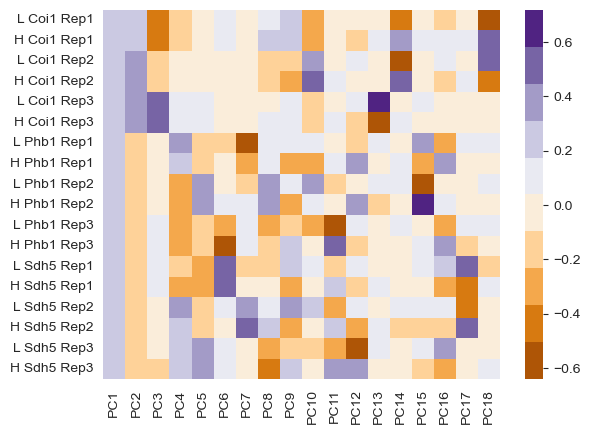

In [7]:
norm_int = pg[norm_cols]
pca = ana.AutoPCA(norm_int, rlabels=norm_int.index, clabels=[x[15] + ' ' + x[17:21] + ' ' + x[22:26] for x in norm_int.columns.to_list()])
pca.corr_comp()

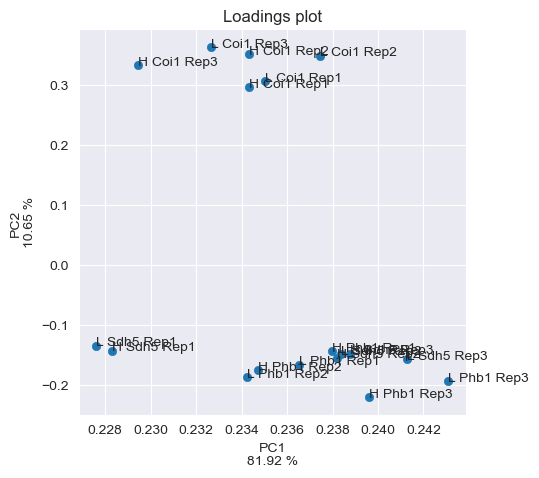

In [8]:
pca.loading_plot(pc1=1, pc2=2, labeling=True)

The observed difference in PC2 most likely stems from different measurement conditions as seen in the continuous instrument raw file numbers: Sdh5 and Phb1 were analysed consecutively whereas Coi1 was analysed later. This shows how important it is to carry controls in each measurement: Wild-type samples for comparison were included in every set of files so that comparison between wild-type and mutant is still feasible.

In [9]:
import pandas as pd
s = archive.open('MaxQuant/summary.txt')
summary = pd.read_csv(s, delimiter='\t', nrows=9)
summary

,Raw file,Experiment,Enzyme,Enzyme mode,Enzyme first search,Enzyme mode first search,Use enzyme first search,Variable modifications,Multi modifications,Variable modifications first search,...,Multiplets Repeatedly Sequenced,Multiplets Repeatedly Sequenced [%],Multiplets Identified,Multiplets Identified [%],Recalibrated,Av. Absolute Mass Deviation [ppm],Mass Standard Deviation [ppm],Av. Absolute Mass Deviation [mDa],Mass Standard Deviation [mDa],Label free norm param
0,QEplus009340,Sdh5_Rep1,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,7060,62.73,1916,17.02,+,0.57177,0.74442,0.37398,0.51660,NaN
1,QEplus009341,Sdh5_Rep2,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,6798,61.02,1707,15.32,+,0.59957,0.78786,0.38628,0.52943,NaN
2,QEplus009343,Sdh5_Rep3,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,6507,60.97,1884,17.65,+,0.56878,0.76499,0.36981,0.52417,NaN
3,QEplus009356,Phb1_Rep1,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,6539,62.32,1687,16.08,+,0.60502,0.80303,0.39401,0.54819,NaN
4,QEplus009357,Phb1_Rep2,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,6935,61.81,1835,16.35,+,0.56877,0.75529,0.36806,0.51721,NaN
5,QEplus009359,Phb1_Rep3,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,6728,60.19,1671,14.95,+,0.60667,0.80749,0.38461,0.53452,NaN
6,QEplus015304,Coi1_Rep1,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,8043,60.87,2780,21.04,+,0.62397,0.81407,0.43513,0.61496,NaN
7,QEplus015306,Coi1_Rep2,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,8068,60.78,2921,22.00,+,0.58654,0.77145,0.42167,0.60006,NaN
8,QEplus015308,Coi1_Rep3,Trypsin/P;LysC/P,Specific,NaN,NaN,False,Oxidation (M);Acetyl (Protein N-term),NaN,NaN,...,8696,61.89,4674,33.27,+,0.50770,0.66680,0.37029,0.52193,NaN


## Analysis based on H/L Ratios
We can analyse SILAC ratios either based on intensity ratios calculated from the MaxQuant intensity columns, or we can use the ratio column of MaxQuant providing H/L ratios. While manual calculation of ratios enables for example missing value imputation before ratio calculation, the ratios derived from MaxQuant are derived from the median ratio of all identified peptides corresponding to a protein group and, therefore, more stable against the effects of outliers. Here we will continue with the MaxQuant ratios.

To account for the label switch, we will invert the ratios of the frist two replicates during log transformation with the autoprot log function. Similar to what we did with the intensities, we will use normalisation of ratios to enable a sound comparison between raw files.

In [10]:
ratio_cols = pg.filter(regex='Ratio H/L normalized .*').columns.to_list()
invert=[-1,-1,1,
        -1,-1,1,
        -1,-1,1,]

# log2 ratio cols
pg, log_ratio_cols = pp.log(pg, ratio_cols, base=2, invert=invert, return_cols=True)
# normalized log2 ratios (assuming that most ratios will be around 1 for most proteins)
pg, norm_ratio_cols = pp.cyclic_loess(pg, log_ratio_cols, return_cols=True)

pg[log_ratio_cols]

,log2_Ratio H/L normalized Coi1_Rep1,log2_Ratio H/L normalized Coi1_Rep2,log2_Ratio H/L normalized Coi1_Rep3,log2_Ratio H/L normalized Phb1_Rep1,log2_Ratio H/L normalized Phb1_Rep2,log2_Ratio H/L normalized Phb1_Rep3,log2_Ratio H/L normalized Sdh5_Rep1,log2_Ratio H/L normalized Sdh5_Rep2,log2_Ratio H/L normalized Sdh5_Rep3
0,-0.116764,-0.183328,-0.176511,NaN,NaN,NaN,NaN,NaN,NaN
1,0.316187,0.673164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,-0.222186,-0.650121,-0.383906,-0.129745,0.082118,0.343578
3,0.938597,0.417637,-1.005232,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.415095,NaN,-0.232170,-0.141694,0.029559,-0.187894,-0.078883,0.032665
...,...,...,...,...,...,...,...,...,...
1083,-0.831715,-0.409472,NaN,NaN,NaN,-0.946110,NaN,1.455811,0.462681
1084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.792657
1085,-0.089498,-0.489029,0.306146,-0.042644,-0.145873,-0.002065,0.286146,0.167993,0.197111
1086,0.030295,0.040809,0.080658,0.165386,0.247851,-0.289351,0.319676,0.262919,0.094371


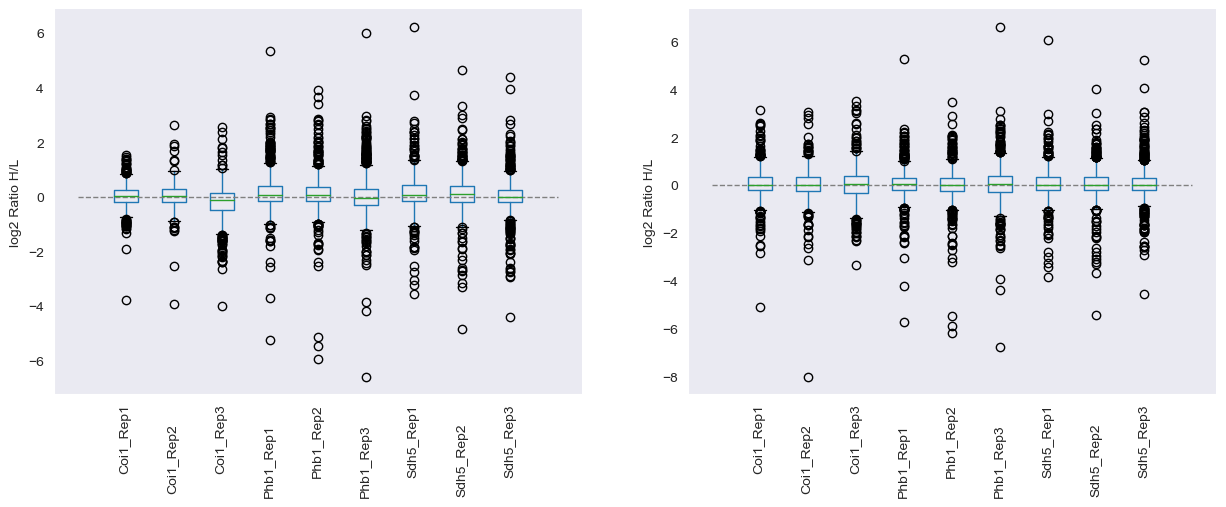

In [11]:
# by direct comparison between nonrmalised and non-normalised ratios, we can see that the effect of the additional treatment is small but noticeable.
fig = vis.boxplot(df=pg, reps=[log_ratio_cols, norm_ratio_cols], labels=[x[26:] for x in log_ratio_cols], ret_fig=True, ylabel='log2 Ratio H/L', compare=True)
for ax in fig.get_axes():
    ax.hlines(y=0, xmin=0, xmax=10, colors='grey', linestyles='dashed', linewidth=1)
    ax.tick_params(axis='x', rotation=90)

To check the correct inversion of the ratios, we plot ratios against intensities for every three replicates. For visualization we highlight a single protein to check if the ratios for all three replicates are similar.

C:\Users\jub29yk\Anaconda3\envs\autoprot\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


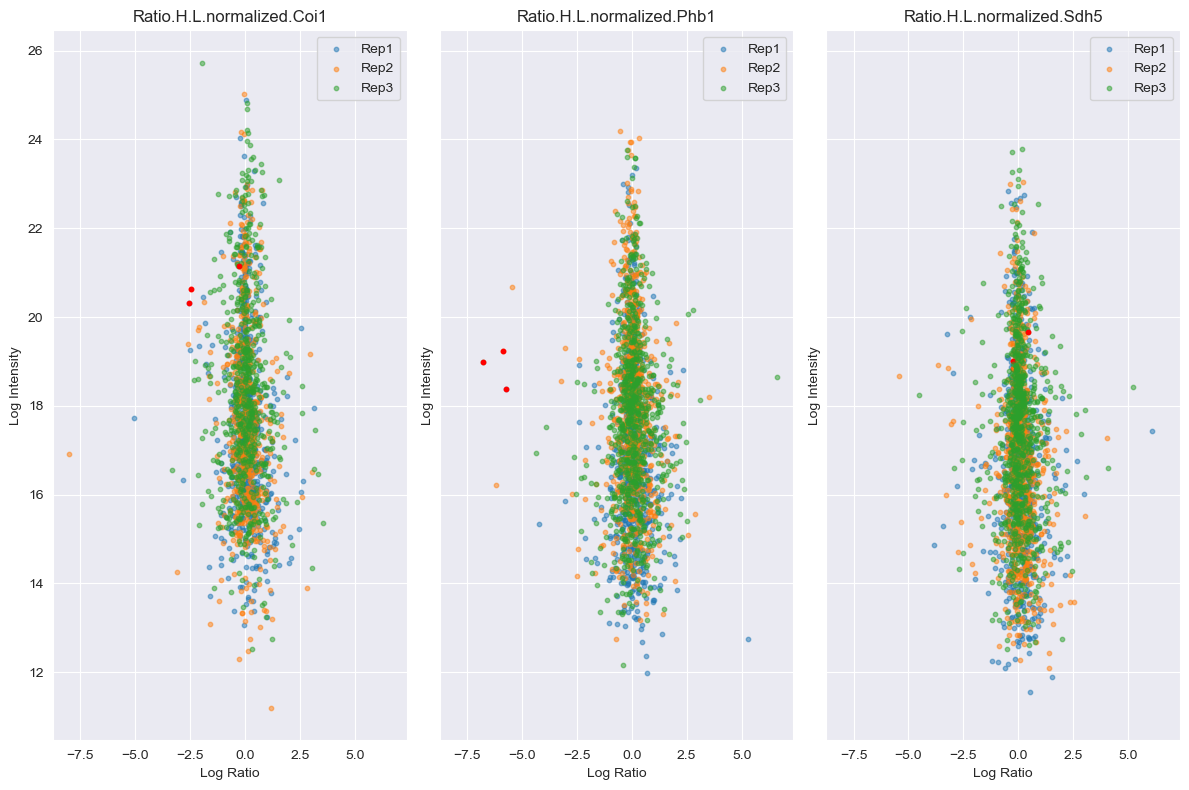

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1,ncols=3, sharex='all', sharey='all', figsize=(12,8))
int_cols = pg.filter(regex='Intensity [^H|L]').columns.to_list()

for idx, col in enumerate(norm_ratio_cols):
    # the column number goes from 0 to 3
    c = idx//3
    this_ax = ax[c]
    # normalised values are plotted on top of the non-normalised values for comparison
    this_ax.scatter(pg[col],
                    np.log(pg[int_cols[idx]]),
                    label=col.split('_')[-2],
                    alpha=0.5,
                    s=10)
    temp = pg[pg['Protein IDs'] == "YGR132C"]
    this_ax.scatter(temp[col],
                    np.log(temp[int_cols[idx]]),
                    label=None,
                    alpha=1,
                    color='red',
                    s=10)

    this_ax.set_xlabel('Log Ratio')
    this_ax.set_ylabel('Log Intensity')
    this_ax.set_title(col.split('_')[1])
    # add a legend for colour scheme
    this_ax.legend()
plt.tight_layout()

### PCA analysis of ratios
Similar to the analysis of intensities we wish to find the different mutant cell lines represented in the principle components. As we are using ratios, wild-type cells are automatically used as normalisation and instrument-based effects as for the intensities should disappear.

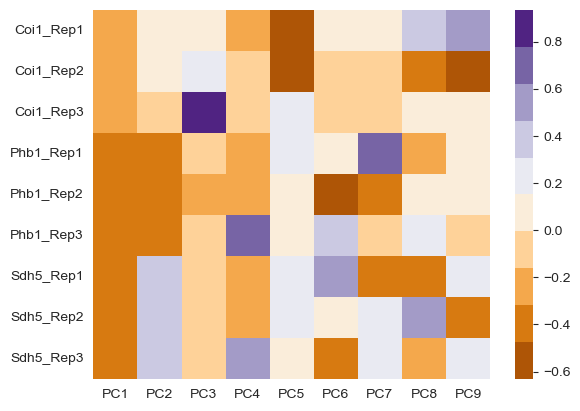

In [13]:
norm_ratio = pg[norm_ratio_cols]
pca = ana.AutoPCA(norm_ratio, rlabels=norm_ratio.index, clabels=[x[26:35] for x in norm_ratio.columns.to_list()])
pca.corr_comp()

We see that the three different KO cell lines group together as expected as the different mutations each have specific effects on the SILAC ratios.

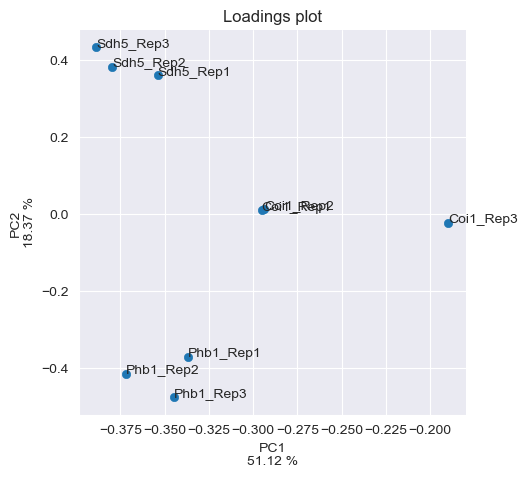

In [14]:
pca.loading_plot(pc1=1, pc2=2, labeling=True)

## Statistical analysis and visualisation
To generate volcano plots for two of the three KO cell lines, we first calculate adjusted p values with the LIMMA linear model. These serve as basis for the volcano plots to highlight the effect of the knockout on the global yeast proteome.

In [15]:
n = 'Sdh5/WT'
pg = ana.limma(df=pg,
               reps=pg.filter(regex='log2_Ratio.*normalized.*Sdh5_Rep\d+_normalized').columns.to_list(),
               cond=f"_limma_{n}")

temp = pg[pg[f'adj.P.Val_limma_{n}'].notnull()]

LIMMA: Assuming a one sample test


For the Sdh5 knockout we highlight all proteins refering to the succinate dehydrogenase (Sdh) complex in their fasta headers. We find that knock-out of Sdh5 indeed has negative consquences for the Sdh complex members.

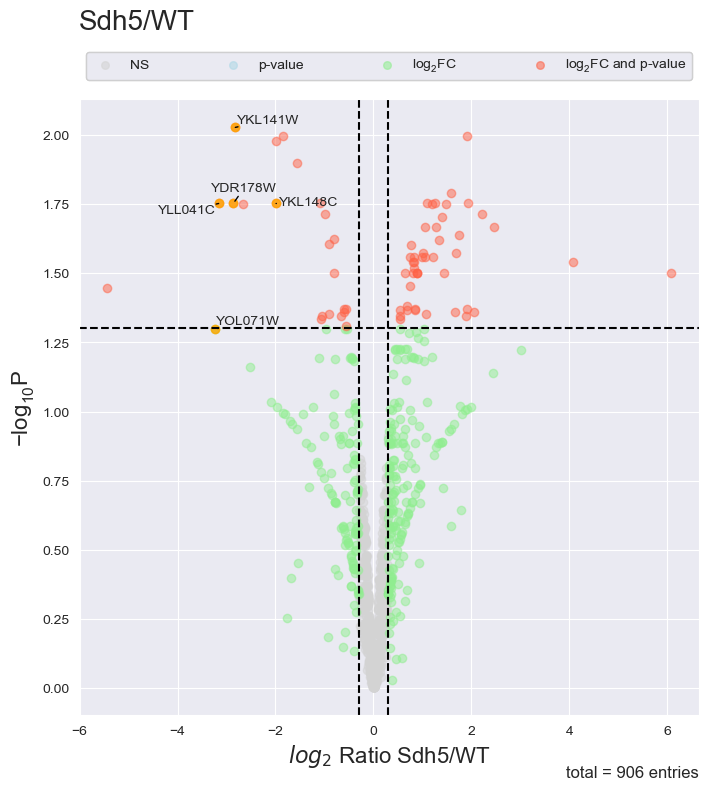

In [16]:
fig = vis.volcano(df=temp,
                  log_fc_colname=f'logFC_limma_{n}',
                  p_colname=f'adj.P.Val_limma_{n}',
                  log_fc_thresh=np.log10(2),
                  p_thresh=0.05,
                  annotate_colname='Protein IDs',
                  annotate='highlight',
                  highlight=temp[temp['Fasta headers'].str.contains('Sdh')].index,
                  title= n,
                  ret_fig=True)
for ax in fig.get_axes():
    ax.set_xlabel(f"$log_2$ Ratio {n}")

In [17]:
import numpy as np
n = 'Phb1/WT'
pg = ana.limma(df=pg,
               reps=pg.filter(regex='log2_Ratio.*normalized.*Phb1_Rep\d+_normalized').columns.to_list(),
               cond=f"_limma_{n}")

LIMMA: Assuming a one sample test


Similarly we highlight all proteins mentioning prohibitin (Phb) in their fasta headers. We see that KO of Prohibitin-1 not only has a negative impact on the protein itself (ID YGR132C) but also on prohibitin-2 (ID YGR231C).

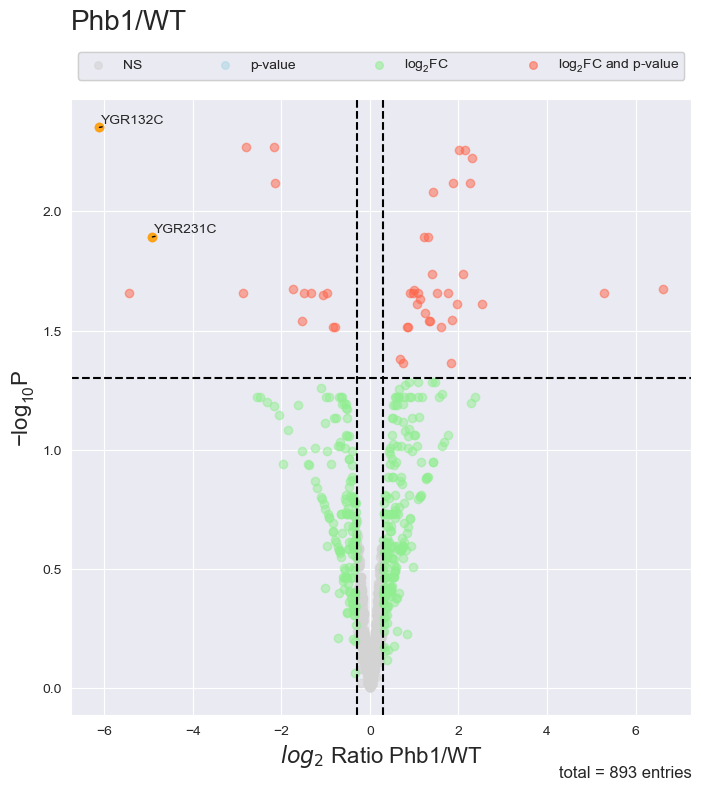

In [18]:
temp = pg[pg[f'adj.P.Val_limma_{n}'].notnull()]
fig = vis.volcano(df=temp,
                  log_fc_colname=f'logFC_limma_{n}',
                  p_colname=f'adj.P.Val_limma_{n}',
                  log_fc_thresh=np.log10(2),
                  p_thresh=0.05,
                  annotate_colname='Protein IDs',
                  annotate='highlight',
                  highlight=temp[temp['Fasta headers'].str.contains('Phb')].index,
                  title= n,
                  ret_fig=True)
for ax in fig.get_axes():
    ax.set_xlabel(f"$log_2$ Ratio {n}")